In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Load data
data_dir = r"D:\coolyeah\semester5\ml\tubes_uas\train_data\train_data"
img_size = 180
batch = 32

# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch,
)

# Total images
total_count = len(dataset) * batch  # Hitung total gambar
print("Total Images: ", total_count)

# Calculate counts for train, validation, and test sets
train_count = int(total_count * 0.8)
val_count = int(total_count * 0.1)
test_count = total_count - train_count - val_count

print("Train Images: ", train_count)
print("Validation Images: ", val_count)
print("Test Images: ", test_count)

# Split dataset into train, validation, and test sets
train_ds = dataset.take(train_count // batch)
val_ds = dataset.skip(train_count // batch).take(val_count // batch)
test_ds = dataset.skip(train_count // batch + val_count // batch).take(test_count // batch)

# Check class names
class_names = dataset.class_names
print("Class Names: ", class_names)


Found 301 files belonging to 3 classes.
Total Images:  320
Train Images:  256
Validation Images:  32
Test Images:  32
Class Names:  ['Busuk', 'Matang', 'Mentah']


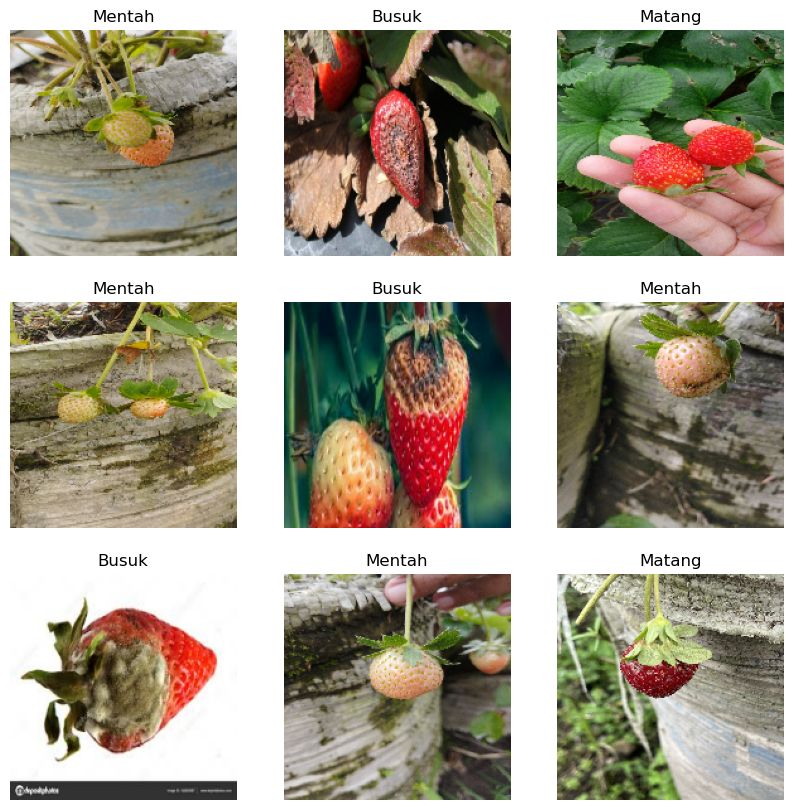

In [5]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        


In [6]:
for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)
    
#loop untuk mengecek atribut gambar(jumlah, tinggi, lebar, dan channel(RGB))

(32, 180, 180, 3)


Loaded 301 images with shape: (301, 180, 180, 3)


c:\Users\capsl\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


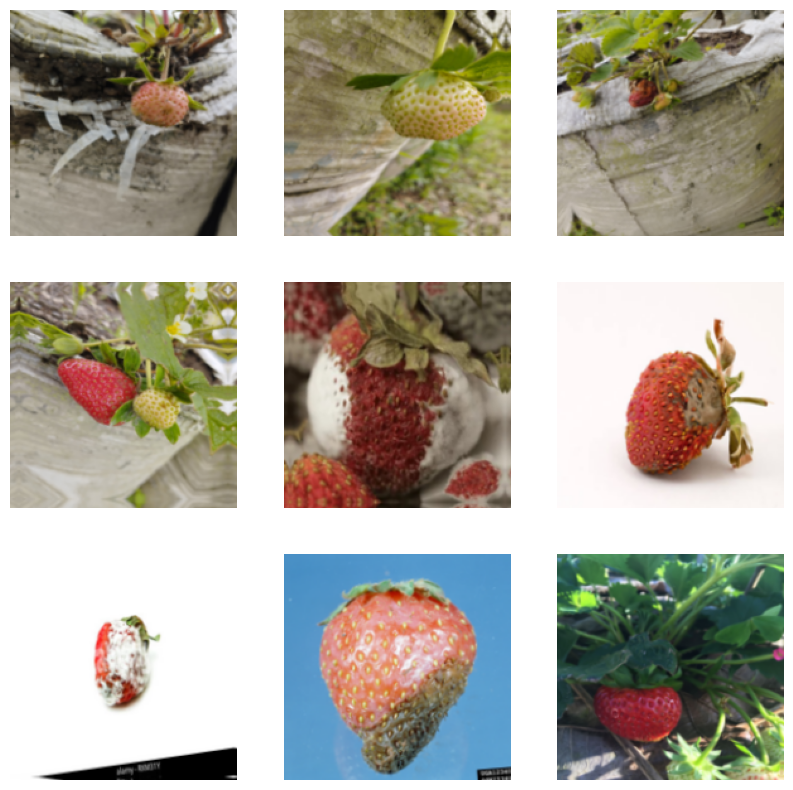

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from PIL import Image
import matplotlib.pyplot as plt

# If using Jupyter Notebook, uncomment the following line
# %matplotlib inline

# Define image size and batch size
img_size = 180  # Example image size
batch_size = 32  # Example batch size

# Define the path to your dataset
data_dir = r"D:\coolyeah\semester5\ml\tubes_uas\train_data\train_data"  # Replace with your dataset path

# Function to load images and labels
def load_images_from_directory(directory):
    images = []
    labels = []
    class_names = os.listdir(directory)  # Get class names from directory
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    file_path = os.path.join(class_dir, file_name)
                    try:
                        img = Image.open(file_path).convert('RGB')  # Open and convert to RGB
                        img = img.resize((img_size, img_size))  # Resize image
                        images.append(np.array(img))  # Convert to numpy array
                        labels.append(label)  # Append label
                    except Exception as e:
                        print(f"Error loading image {file_path}: {e}")
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_from_directory(data_dir)

# Check the shape of the loaded images
print(f"Loaded {len(images)} images with shape: {images.shape}")

# Create a TensorFlow dataset
train_ds = tf.data.Dataset.from_tensor_slices((images, labels))

# Shuffle and batch the dataset
Tuner = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=Tuner)

# Data augmentation using Sequential
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_size, img_size, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# Visualize augmented images
plt.figure(figsize=(10, 10))
for images_batch, labels_batch in train_ds.take(1):
    augmented_images = data_augmentation(images_batch)  # Apply data augmentation
    for i in range(min(9, augmented_images.shape[0])):  # Ensure we don't exceed the number of images
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype('uint8'))
        plt.axis('off')
plt.show()

In [190]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def googlenet(input_shape, n_classes):
    
    def inception_block(x, filters):
        # 1x1 Convolution
        branch1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)
        branch1x1 = BatchNormalization()(branch1x1)

        # 1x1 Convolution followed by 3x3 Convolution
        branch3x3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
        branch3x3 = BatchNormalization()(branch3x3)
        branch3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch3x3)
        branch3x3 = BatchNormalization()(branch3x3)

        # 1x1 Convolution followed by 5x5 Convolution
        branch5x5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
        branch5x5 = BatchNormalization()(branch5x5)
        branch5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(branch5x5)
        branch5x5 = BatchNormalization()(branch5x5)

        # 3x3 MaxPooling followed by 1x1 Convolution
        branch_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(branch_pool)
        branch_pool = BatchNormalization()(branch_pool)

        # Concatenate all branches
        outputs = layers.concatenate([branch1x1, branch3x3, branch5x5, branch_pool], axis=-1)
        return outputs

    input = Input(shape=input_shape)

    # Initial Convolution Layer
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Inception Blocks
    x = inception_block(x, [64, 128, 128, 32, 32, 32])
    x = inception_block(x, [128, 128, 192, 96, 96, 64])
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = inception_block(x, [192, 96, 208, 16, 48, 64])
    x = inception_block(x, [160, 112, 224, 24, 64, 64])
    x = inception_block(x, [128, 128, 256, 24, 64, 64])
    x = inception_block(x, [112, 144, 288, 32, 64, 64])
    x = inception_block(x, [256, 160, 320, 32, 128, 128])
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = inception_block(x, [256, 160, 320, 32, 128, 128])
    x = inception_block(x, [384, 192, 384, 48, 128, 128])

    # Average Pooling and Fully Connected Layer
    x = AveragePooling2D((7, 7))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    output = Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs=input, outputs=output)
    return model

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Input shape and class names
input_shape = (180, 180, 3)
class_names = ['Busuk', 'Matang', 'Mentah'] 
n_classes = len(class_names)

# Clear Keras session
tf.keras.backend.clear_session()

# Create model
model = googlenet(input_shape, n_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 90, 90,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 90, 90,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 44, 44,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 44, 44,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 44, 44,    │      2,080 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 44, 44,    │          0 │ max_pooling2d[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 44, 44,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 44, 44,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 44, 44,    │     25,632 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 44, 44,    │      2,080 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │        128 │ conv2d_6[0][0]  

 Total params: 6,346,531 (24.21 MB)

 Trainable params: 6,332,259 (24.16 MB)

 Non-trainable params: 14,272 (55.75 KB)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 506ms/step - accuracy: 0.2643 - loss: 1206.0455
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 497ms/step - accuracy: 0.5002 - loss: 60.9073
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 503ms/step - accuracy: 0.8891 - loss: 0.8052
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 495ms/step - accuracy: 0.9375 - loss: 0.2679
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 505ms/step - accuracy: 0.9636 - loss: 0.2360
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 490ms/step - accuracy: 0.9962 - loss: 0.0685
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 499ms/step - accuracy: 0.9991 - loss: 0.0143
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 502ms/step - accuracy: 0.9794 - loss: 0.0800
Epoch 9/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 498ms/step - accuracy: 1.0000 - loss: 0.0292
Epoch 10/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - accuracy: 1.0000 - loss: 0.0104
Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 499ms/step - accuracy: 1.0000 - loss: 0.0121
Epoch 12/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 499ms/

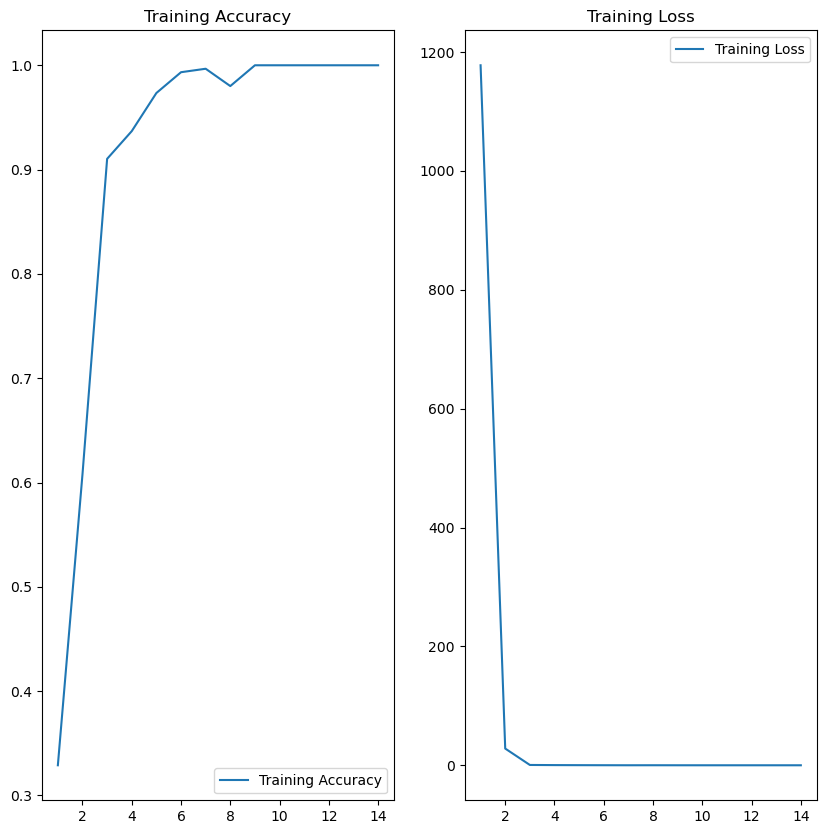

In [186]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plt

# Define image size and batch size
img_size = 180  # Ukuran gambar
batch_size = 32  # Ukuran batch
num_classes = 10  # Ganti dengan jumlah kelas yang sesuai

# Define the path to your dataset
data_dir = r"D:\coolyeah\semester5\ml\tubes_uas\train_data\train_data"  # Ganti dengan path dataset Anda

# Function to load images and labels
def load_images_from_directory(directory):
    images = []
    labels = []
    class_names = os.listdir(directory)  # Mendapatkan nama kelas dari direktori
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    file_path = os.path.join(class_dir, file_name)
                    try:
                        img = Image.open(file_path).convert('RGB')  # Buka dan konversi ke RGB
                        img = img.resize((img_size, img_size))  # Ubah ukuran gambar ke (180, 180)
                        images.append(np.array(img))  # Konversi ke numpy array
                        labels.append(label)  # Tambahkan label
                    except Exception as e:
                        print(f"Error loading image {file_path}: {e}")
    return np.array(images), np.array(labels)

# Load training images and labels
images, labels = load_images_from_directory(data_dir)

# Create a TensorFlow dataset for training
train_ds = tf.data.Dataset.from_tensor_slices((images, labels))  # Gunakan labels asli
train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Define a simple CNN model
model = tf.keras.Sequential([
    layers.Input(shape=(img_size, img_size, 3)),  # Input layer untuk gambar
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),  # Flatten the output
    layers.Dense(512, activation='relu'),  # Dense layer
    layers.Dense(num_classes, activation='softmax')  # Output layer untuk num_classes
])

# Compile dengan optimizer Adam
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',  # Gunakan sparse_categorical_crossentropy
    metrics=['accuracy']
)

# Buat early stopping
early_stopping = EarlyStopping(monitor='accuracy', patience=5, mode='max')

# Fit model tanpa validation_data
history = model.fit(train_ds, 
                    epochs=30, 
                    callbacks=[early_stopping])

# Buat plot dengan menggunakan history supaya jumlahnya sesuai epoch yang dilakukan
epochs_range = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [187]:
model.save('gNet5.h5')

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

# Load the trained model
model = load_model(r'D:\coolyeah\semester5\ml\tubes_uas\BestModel_GoogleNet_Matplotlib.h5')  # Ganti dengan path model Anda
class_names = ['Busuk', 'Matang', 'Mentah']

# Function to classify images and save the original image
def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        # Load and preprocess the image
        input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)  # Add batch dimension

        # Predict
        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result)
        confidence = np.max(result) * 100

        # Display prediction and confidence in notebook
        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        # Save the original image (without text)
        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

# Contoh penggunaan fungsi
###Terdapat code yang hilang disini! lihat modul untuk menemukanya
result = classify_images(r'D:\coolyeah\semester5\ml\tubes_uas\test_data\test_data\Busuk\busuk_02.jpg', save_path='busuk_01.jpg')
result = classify_images(r'D:\coolyeah\semester5\ml\tubes_uas\test_data\test_data\Matang\matang_05.jpg', save_path='matang_01.jpg')
result = classify_images(r'D:\coolyeah\semester5\ml\tubes_uas\test_data\test_data\Mentah\mentah_04.jpg', save_path='mentah_01.jpg')
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Prediksi: Busuk
Confidence: 23.20%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediksi: Matang
Confidence: 23.20%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediksi: Mentah
Confidence: 23.20%
Prediksi: Mentah dengan confidence 23.20%. Gambar asli disimpan di mentah_01.jpg.


Found 36 files belonging to 1 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


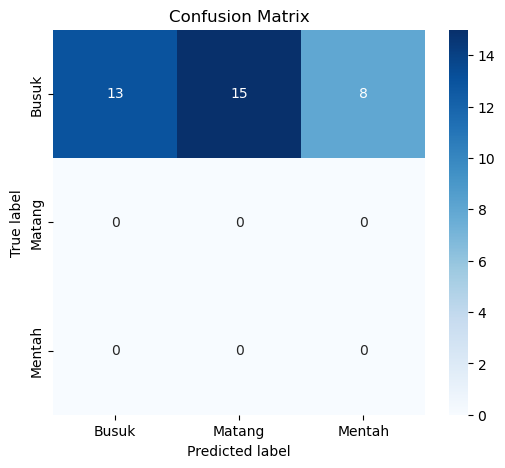

Confusion Matrix: 
 [[13 15  8]
 [ 0  0  0]
 [ 0  0  0]]
Akurasi:  0.3611111111111111
Presisi:  [1. 0. 0.]
Recall:  [0.36111111        nan        nan]
F1 Score:  [0.53061224        nan        nan]


In [213]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

# Muat data test yang sebenarnya
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'test_data',
    labels='inferred',
    label_mode='categorical',  # Menghasilkan label dalam bentuk one-hot encoding
    batch_size=32,
    image_size=(180, 180)
)

# Prediksi model
y_pred = model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)  # Konversi ke kelas prediksi

# Ekstrak label sebenarnya dari test_data dan konversi ke bentuk indeks kelas
true_labels = []
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())  # Konversi one-hot ke indeks kelas
true_labels = tf.convert_to_tensor(true_labels)

# Membuat matriks kebingungan
conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

# Menghitung akurasi
accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

# Menghitung presisi dan recall
precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

# Menghitung F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Busuk", "Matang", "Mentah"], yticklabels=["Busuk", "Matang", "Mentah"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Menampilkan hasil
print("Confusion Matrix: \n", conf_mat.numpy())
print("Akurasi: ", accuracy.numpy())
print("Presisi: ", precision.numpy())
print("Recall: ", recall.numpy())
print("F1 Score: ", f1_score.numpy())